# Исследование объявлений о продаже квартир
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.


#### Часть 1. Подготовка
* [1.Изучение файлов, получение общей информации.](#part1)

#### Часть 2. Предобработка данных
* [1.Обработка дубликатов.](#part2.1)
* [2.Обработка пропусков.](#part2.2) 
* [3.Замена типов данных.](#part2.3) 
 
#### [Часть 3. Добавление данных в таблицу](#part3.1)

#### Часть 4. Исследовательский анализ данных
* [1 Изучение параметров квартир, постройка гистограмм.](#part4.1)
* [2. Изучение времени продажи квартир](#part4.2)
* [3. Редкие и выбивающиеся значения.](#part4.3)
* [4. Факторы, влияющие на стоимость квартиры](#part4.4)
* [5. Стоимость квадратного метра в разных городах..](#part4.5)
* [6. Определение квартир, находящихся в центре Санкт-Петербурга](#part4.6)
* [7. Сравнение квартир в центре Санкт-Петербурга со всеми квартирами Санкт-Петербурга](#part4.7)
#### [Общий вывод](#part5)
#### [Чек-лист готовности проекта](#part6)


## Часть 1. Подготовка.
<a id='part1'></a>
### Изучение файлов, получение общей информации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
df.info()
print(df.head())

print(df['locality_name'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Видны пропуски в столбцах: ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, airports_nearest, 
cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.

Значения в столбцах floors_total, balcony, parks_around3000, ponds_around3000, days_exposition можно сменить на тип int.

В столбце с названиями населенных пунктов обнаружены дубликаты. Названия необходимо привести к общему виду.

## Часть 2. Предобработка данных.
<a id='part2.1'></a>
### 2.1 Обработка дубликатов.

In [2]:
print('Количество населенных пунктов до обработки: ',len(df['locality_name'].unique()))
# Убираем пропуски в названиях и приводим названия к одному виду
df = df[df['locality_name'].notnull()]
# Функция для переименования населенных пунктов
def new_locality_name(row):
    locality_name = row['locality_name'] 
    
    for i in range(len(locality_name.split())): # Делим строку на слова
        answ=''
        if locality_name.split()[i].istitle(): # Если слово начинается с заглавной буквы, формируем название города
            name = locality_name.split()[i:]
            if len(name)==2:                   # Если название города состоит из 2 слов 
                name = name[0] + ' ' + name[1]
            if len(name)==3:                   # Если название города состоит из 3 слов
                name = name[0] + ' ' + name[1] + ' ' + name[2]
            return answ.join(name)
        
df['new_locality_name'] = df.apply(new_locality_name, axis=1)
df['locality_name'] = df['new_locality_name']

#(df['locality_name'].unique())
print('Количество населенных пунктов после обработки: ',len(df['locality_name'].unique()))
print('Количество дубликатов в данных:', df.duplicated().sum()) #проверка на дубликаты

Количество населенных пунктов до обработки:  365
Количество населенных пунктов после обработки:  305
Количество дубликатов в данных: 0


### Вывод
Удалены дубликаты в названиях населенных пунктов.

<a id='part2.2'></a>
### 2.2 Обработка пропусков.

In [3]:
print('Количество студий:', len(df.loc[df['studio']==True]))
print('Количество квартир с открытой планировкой:', len(df.loc[df['open_plan']==True]))
# Нестандартных квартир всего 159. Удаляем.
df = df.query("studio == False and open_plan == False")
     
# Пропуски в количетсве балконов заполним нулем, предполагая, что если количество балконов не указано, то их нет.
df['balcony'] = df['balcony'].fillna(0)
# Пропуски в столбцах parks_around3000 и ponds_around3000 также заполняем нулями, 
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
# Пропуски в столбце is_apartment заменяем значением False
df['is_apartment'] = df['is_apartment'].fillna(False)
# Пропуски в столбце days_exposition заменяем значением 0
df['days_exposition'] = df['days_exposition'].fillna(0)

# Пропуски в количестве этажей заполним значением этажа (считаем, что квартира на последнем этаже)
def fill_floors_total(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if pd.isnull(floors_total):
        return floor
    else:
        return floors_total
# применяем функцию, меняем значения в столбце
df['new_floors_total'] = df.apply(fill_floors_total, axis=1)
df['floors_total'] = df['new_floors_total']

# Пропуски в площади кухни заполним средним значением этой 
# площади для квартир с таким же кол-вом комнат в домах с таким же кол-вом этажей
def fill_kitchen_area(row):
    kitchen_area = row['kitchen_area']
    floors_total = row['floors_total']
    total_area = row['total_area']
    
    if pd.isnull(kitchen_area):
        return df['kitchen_area'].loc[(df['floors_total'] == floors_total) &
                                          (df['total_area'] == total_area)].mean() 
    else:
        return kitchen_area

df['new_kitchen_area'] = df.apply(fill_kitchen_area, axis=1)
df['kitchen_area'] = df['new_kitchen_area']


# Пропуски в жилой площади заполним средним значением этой 
# площади для квартир с такой же общей площадью в домах с таким же кол-вом этажей
def fill_living_area(row):
    living_area = row['living_area']
    floors_total = row['floors_total']
    total_area = row['total_area']
    if pd.isnull(living_area):
        return df['living_area'].loc[(df['floors_total'] == floors_total) &
                                    (df['total_area'] == total_area)].mean() 
    else:
        return living_area
df['new_living_area'] = df.apply(fill_living_area, axis=1)
df['living_area'] = df['new_living_area']

#Оставшиеся пропуски в площадях удаляем.
df.dropna(subset=['living_area', 'kitchen_area'], inplace=True)

# Пропуски в высоте потолков заполним средним значением этой 
# высоты для квартир с такой же общей площадью в домах с таким же кол-вом этажей
def fill_ceiling_height(row):
    ceiling_height = row['ceiling_height']
    floors_total = row['floors_total']
    rooms = row['rooms']
    if pd.isnull(ceiling_height):
        
        return df['ceiling_height'].loc[(df['floors_total'] == floors_total) &
                                          (df['rooms'] == rooms)].mean()                                           
    else:
        return ceiling_height

    
#применяем функцию, создаем новый столбец с данными и заменяем данные в старом столбце на новые
df['new_ceiling_height'] = df.apply(fill_ceiling_height, axis=1)
df['ceiling_height'] = df['new_ceiling_height']
# Оставшиеся пропуски в высоте потолков заменим средней высотой.
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].mean())



# Удаляем ненужные столбцы
df.drop(['new_floors_total','new_ceiling_height','new_living_area','new_kitchen_area','open_plan','studio','new_locality_name'],
        axis='columns', inplace=True)



df.info()

Количество студий: 149
Количество квартир с открытой планировкой: 67
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22674 entries, 0 to 23698
Data columns (total 20 columns):
total_images            22674 non-null int64
last_price              22674 non-null float64
total_area              22674 non-null float64
first_day_exposition    22674 non-null object
rooms                   22674 non-null int64
ceiling_height          22674 non-null float64
floors_total            22674 non-null float64
living_area             22674 non-null float64
floor                   22674 non-null int64
is_apartment            22674 non-null bool
kitchen_area            22674 non-null float64
balcony                 22674 non-null float64
locality_name           22674 non-null object
airports_nearest        17440 non-null float64
cityCenters_nearest     17462 non-null float64
parks_around3000        22674 non-null float64
parks_nearest           7786 non-null float64
ponds_around3000        22674 non-n

### Вывод
Пропуски в высоте потолков были заполнены средним значением высоты потолков для квартир с таким же количеством комнат в домах с таким же количеством этажей.

Пропуски в количестве этажей были заменены значением этажа (считаем, что квартира находится на последнем этаже).

Пропуски в площади кухни на среднее значение площади кухни для квартир с такой же общей площадью в домах с таким же количеством этажей.

Пропуски в жилой площади заменены на среднее значение жилой площади для квартир с такой же общей площадью в домах с таким же количеством этажей.

Пропуски в данных о балконах, наличии поблизости водоемов и парков были заполнены нулями на основании утверждения, что если эти данные отстутсвуют, то значит балконов, водоемов и парков нет.

Пропуски в столбцах с расстояниями было решено не заполнять, т.к. заполнить близкими по смыслу значениями не предоставляется возможным, а заполнение усредненными значениями помешает дальнейшим исследованиям.

Пропуски в столбце days_exposition скорее всего означают, что квартира до сих пор не продана, поэтому они были заменены на 0.

<a id='part2.3'></a>
### 2.3 Замена типов данных.

In [4]:
#Меняем данные в столбцах на int
df['floors_total'] = df['floors_total'].astype(int)
df['balcony'] = df['balcony'].astype(int)
df['parks_around3000'] = df['parks_around3000'].astype(int)
df['ponds_around3000'] = df['ponds_around3000'].astype(int)
df['days_exposition'] = df['days_exposition'].astype(int)
df['last_price'] = df['last_price'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22674 entries, 0 to 23698
Data columns (total 20 columns):
total_images            22674 non-null int64
last_price              22674 non-null int64
total_area              22674 non-null float64
first_day_exposition    22674 non-null object
rooms                   22674 non-null int64
ceiling_height          22674 non-null float64
floors_total            22674 non-null int64
living_area             22674 non-null float64
floor                   22674 non-null int64
is_apartment            22674 non-null bool
kitchen_area            22674 non-null float64
balcony                 22674 non-null int64
locality_name           22674 non-null object
airports_nearest        17440 non-null float64
cityCenters_nearest     17462 non-null float64
parks_around3000        22674 non-null int64
parks_nearest           7786 non-null float64
ponds_around3000        22674 non-null int64
ponds_nearest           8670 non-null float64
days_exposition      

### Вывод

Для всех значений, для которых это возможно(количество этажей, количество балконов, количество парков в радиусе 3км, количество водоемов в радиусе 3км), была проведена замена типа данных с float на int.

<a id='part3.1'></a>
## Часть 3. Добавление данных в таблицу

In [5]:
# Добавим в таблицу цену квадратного метра
df['meter_price'] = df['last_price'] / df['total_area']

# Перевод строки с датой в фомат datetime
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# Добавляем в таблицу год, месяц и день недели даты выставления квартиры на продажу
df['year'] = df['first_day_exposition'].dt.year
df['month'] = df['first_day_exposition'].dt.month
df['day_of_week'] = df['first_day_exposition'].dt.weekday

# Функция для определения категории этажа (первый, последний, другой)
def floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor / floors_total == 1:
        return 'последний'
    else:
        return 'другой'
df['floor_cat'] = df.apply(floor, axis=1)

# Добавим в таблицу отношение жилой площади к общей и отношение площади кухни к общей
df['living_ratio'] = df['living_area'] / df['total_area']
df['kitchen_ratio'] = df['kitchen_area'] / df['total_area']

print(df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
4             2    10000000       100.0           2018-06-19      2   
5            10     2890000        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0        2.700000            16         51.0      8         False  ...   
1        2.776842            11         18.6      1         False  ...   
2        2.726004             5         34.3      4         False  ...   
4        3.030000            14         32.0     13         False  ...   
5        2.633409            12         14.4      5         False  ...   

   ponds_around3000  ponds_nearest days_exposition    meter_price  year  \
0                 2          755.0               0  1

<a id='part3.4'></a>
### Вывод

В таблицу были добавлены следующие столбцы: цена квадратного метра, день недели, месяц и год публикации объявления, категория этажа (первый, последний, другой), а также отношение жилой площади жилой и площади кухни к общей площади квартиры.

## Часть 4. Исследовательский анализ данных
<a id='part4.1'></a>
### 4.1 Изучение параметров квартир, постройка гистограмм.

#### Изучение цен на квартиры

count    2.267400e+04
mean     6.423958e+06
std      9.342787e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.750000e+06
max      4.200000e+08
Name: last_price, dtype: float64


(array([ 624., 3063., 6831., 5032., 2468., 1463.,  794.,  556.,  407.,
         347.]),
 array([       0.,  1500000.,  3000000.,  4500000.,  6000000.,  7500000.,
         9000000., 10500000., 12000000., 13500000., 15000000.]),
 <a list of 10 Patch objects>)

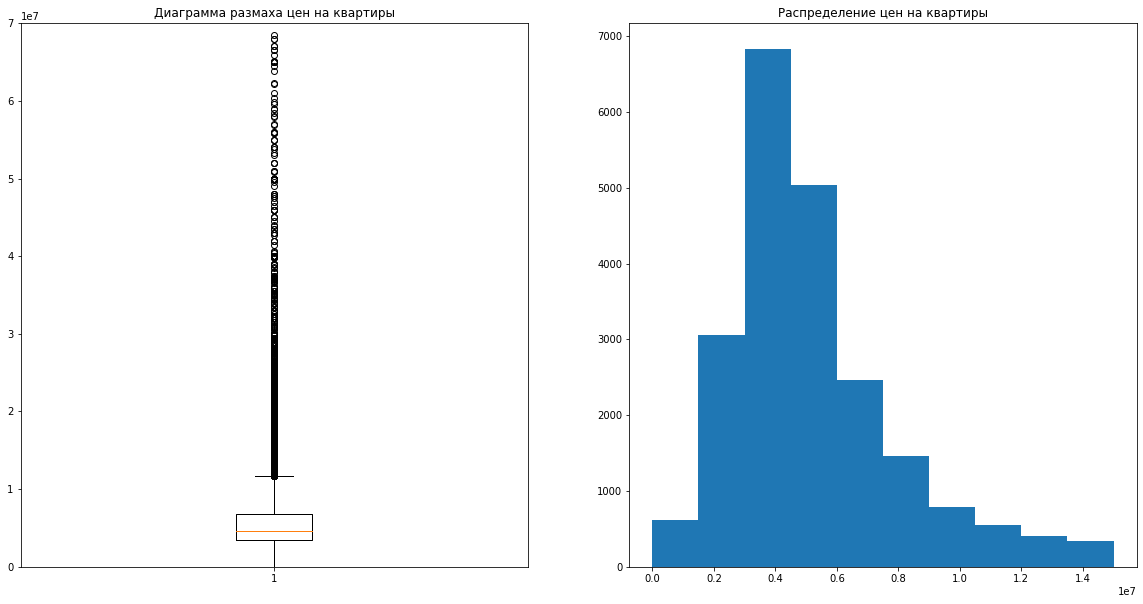

In [6]:
# Получим описательные хар-ки цены
print(df['last_price'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха цен на квартиры')
ax[0].set_ylim(0, 70000000)
ax[0].boxplot(x=df['last_price'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение цен на квартиры')
ax[1].hist(x=df['last_price'], range=(0,15000000))


#### Вывод
Большая часть квартир находится в ценовом сегменте от 2 до 7 млн. Цены выше 15 млн при построении не учитывались.

#### Изучение площади квартир

count    22674.000000
mean        60.176688
std         33.899197
min         14.000000
25%         40.400000
50%         52.000000
75%         69.500000
max        900.000000
Name: total_area, dtype: float64


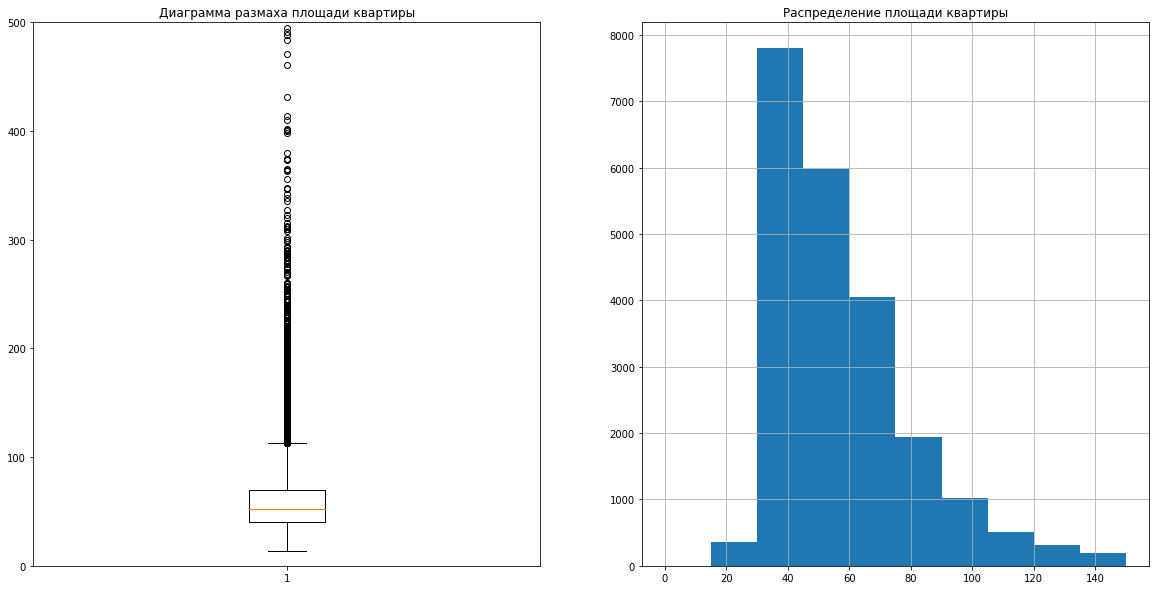

In [7]:
# Получим описательные хар-ки площади
print(df['total_area'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха площади квартиры')
ax[0].set_ylim(0, 500)
ax[0].boxplot(x=df['total_area'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение площади квартиры')
ax[1].hist(x=df['total_area'], range=(0,150))
ax[1].grid()

#### Вывод
Большая часть квартир имеют площадь от 30 до 70 кв метров. Квартиры с площадью больше 150 кв метров при построении распределения не учитывались.

В данных присутствуют квартиры с площадью более 400 кв метров.

#### Изучение количества комнат

count    22674.000000
mean         2.087898
std          1.057343
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


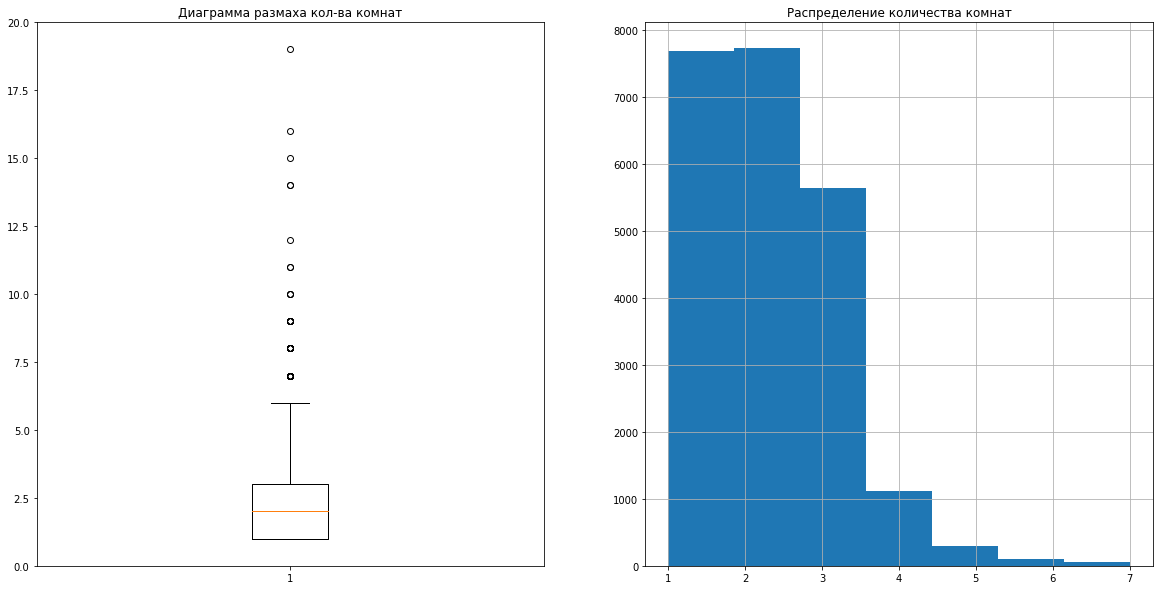

In [8]:
# Получим описательные хар-ки площади
print(df['rooms'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха кол-ва комнат')
ax[0].set_ylim(0, 20)
ax[0].boxplot(x=df['rooms'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение количества комнат')
ax[1].hist(x=df['rooms'], bins=7,range=(1,7))
ax[1].grid()

#### Вывод
Помним, что во время предобработки было удалено 149 студий.
В основном квартиры имеют от 1 до 3 комнат.
Присутсвует несколько квартир с 6 комнатами и больше.

#### Изучение высоты потолков

count    22674.000000
mean         2.765685
std          1.002232
min          1.000000
25%          2.586121
50%          2.700000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


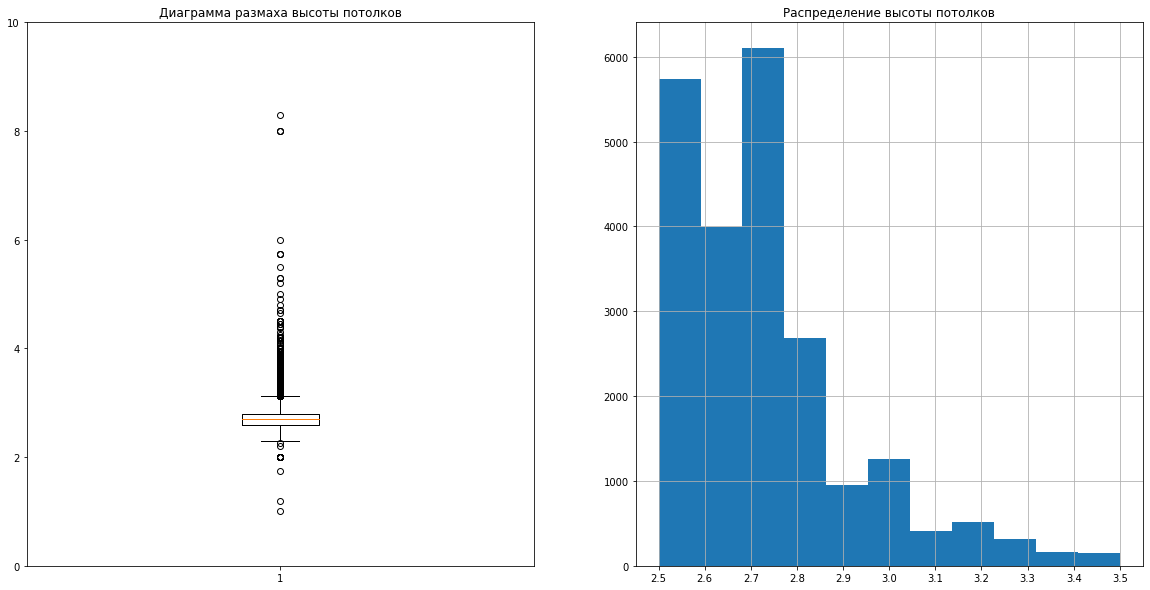

In [9]:
# Получим описательные хар-ки площади
print(df['ceiling_height'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха высоты потолков')
ax[0].set_ylim(0, 10)
ax[0].boxplot(x=df['ceiling_height'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение высоты потолков')
ax[1].hist(x=df['ceiling_height'], bins=11,range=(2.5,3.5))
ax[1].grid()
ax[1].set_xticks([2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5])

#### Вывод
Большая часть квартир имеет высоту потолков от 2.5 до 2.8 метров. Присутствуют выбросы с высотами потолков 1 м и 100 м.

<a id='part4.2'></a>
### 4.2 Изучение времени продажи квартир

count    19606.000000
mean       182.088085
std        220.054336
min          1.000000
25%         45.000000
50%         97.000000
75%        233.000000
max       1580.000000
Name: days_exposition, dtype: float64
10% квантиль:  17.0
90% квантиль:  462.0


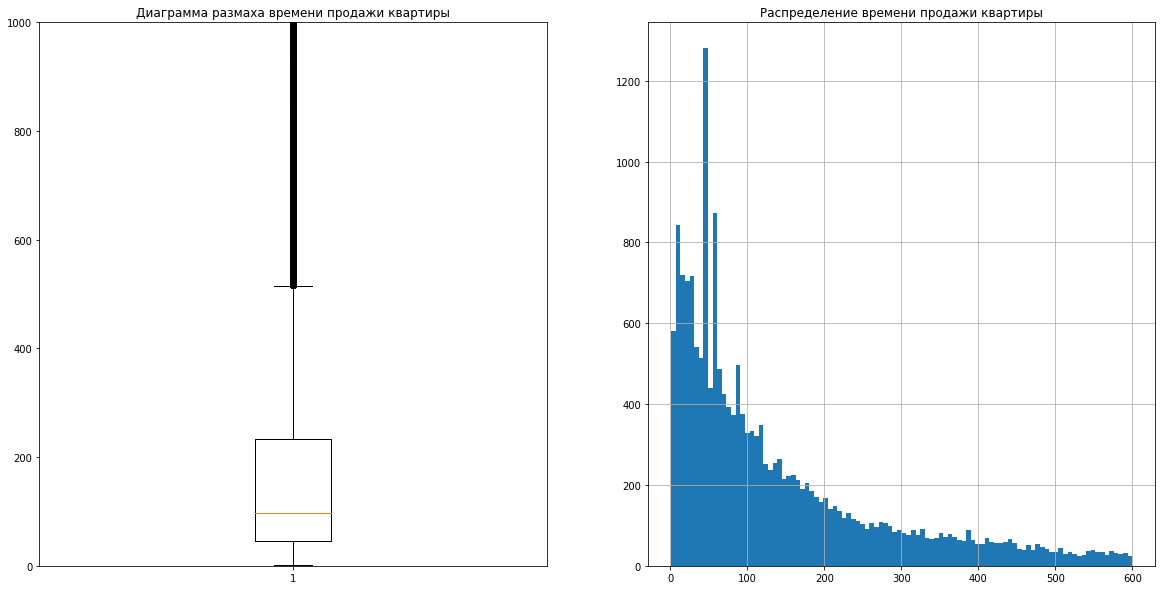

In [10]:
# Получим описательные хар-ки площади
print(df.query('days_exposition != 0')['days_exposition'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха времени продажи квартиры')
ax[0].set_ylim(0, 1000)
ax[0].boxplot(x=df.query('days_exposition != 0')['days_exposition'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение времени продажи квартиры')
ax[1].hist(x=df.query('days_exposition != 0')['days_exposition'], bins = 100, range=(1,600))
ax[1].grid()
print('10% квантиль: ', df.query('days_exposition != 0')['days_exposition'].quantile(0.1))
print('90% квантиль: ', df.query('days_exposition != 0')['days_exposition'].quantile(0.9))

Среднее время продажи 182 дней.

Медиана времени продажи 97 дней.

Обычное время продажи оценим как межквартильный размах. То есть от 45 до 234 дней.

Быстрой продажей можно считать продажи, находящиеся до 10% квантиля, т.е. проданные быстрее, чем за 17 дней.

Долгой продажей можно считать продажи, находящиеся после 90% квантиля, т.е. проданные больше, чем за 462 дня.

Присутствует несколько пиков, выделяющихся из общей картины: 
7, 30, 45, 60, 90 дней. 

Скорее всего, это связано с тем, что с такой "круглой" периодичностью (неделя, один, полтора, два, три месяца) квартиры перевыставляются на продажу. То есть если в течение какого-то промежутка времени квартира не покупается, то объявление обновляется.

Если это учесть и выбросить данные с таким значением days_exposition, то оценка времени продажи примет другой вид.

count    17718.000000
mean       196.488881
std        226.680770
min          1.000000
25%         46.000000
50%        115.000000
75%        260.000000
max       1580.000000
Name: days_exposition, dtype: float64
10% квантиль:  17.0
90% квантиль:  486.0


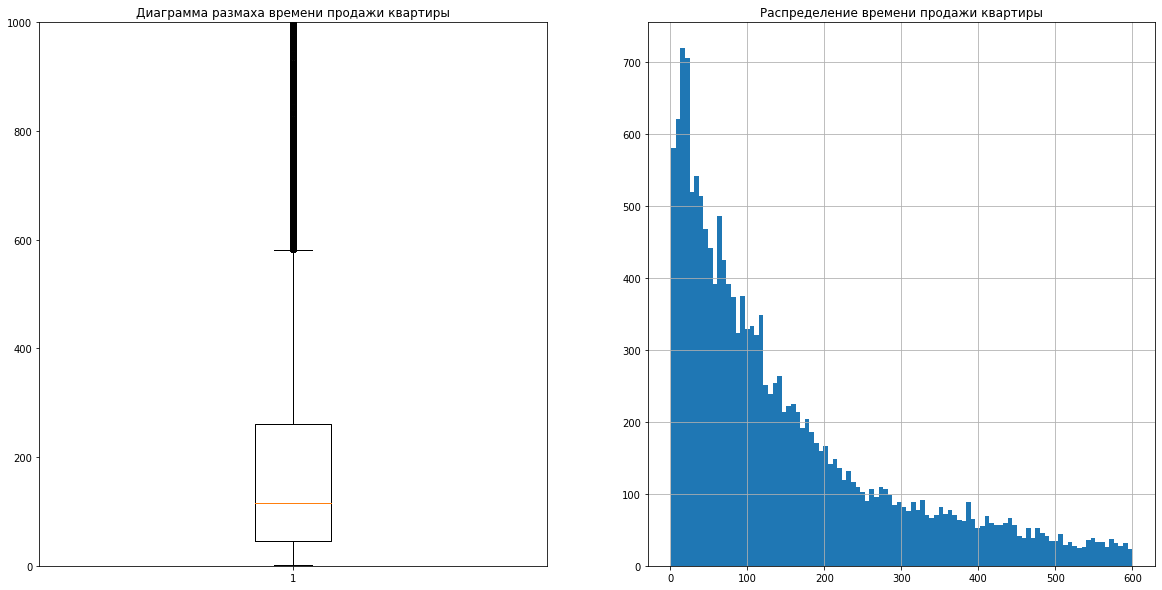

In [11]:
df_new_days = df.query('days_exposition != 0 and days_exposition != 7 and days_exposition != 30 \
                       and days_exposition != 45 and days_exposition != 60 and days_exposition != 90')


# Получим описательные хар-ки площади
print(df_new_days['days_exposition'].describe())
# Построим ящик с усами
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Диаграмма размаха времени продажи квартиры')
ax[0].set_ylim(0, 1000)
ax[0].boxplot(x=df_new_days['days_exposition'])
# На основании ящика выбираем границы гистограммы
ax[1].set_title('Распределение времени продажи квартиры')
ax[1].hist(x=df_new_days['days_exposition'], bins = 100, range=(1,600))
ax[1].grid()
print('10% квантиль: ', df_new_days['days_exposition'].quantile(0.1))
print('90% квантиль: ', df_new_days['days_exposition'].quantile(0.9))

После удаления нестандартных значений срока публикации объявления, среднее и медиана времени продажи увеличились.

Таким образом, распределение срока продажи немного растянулось вверх.

Распределение стало еще больше напоминать распределение Пуассона.

Время быстрой продажи (до квантиля 10%) осталось таким же (17 дней).
Время долгой продажи (после квантиля 90%) увеличилось (486 дней).


<a id='part4.3'></a>
### 4.3 Редкие и выбивающиеся значения.

In [12]:
# Считаем выбросами все значения, которые на диаграммах размаха выглядят отдельными выбросами.

# Функии для подсчета границ усов

def low_border(column):
    return column.quantile(0.25) - 1.5*(column.quantile(0.75)-column.quantile(0.25))
def high_border(column):
    return column.quantile(0.75) + 1.5*(column.quantile(0.75)-column.quantile(0.25))

# Создаем новый датасет с исключенными выбросами
# В диаграмме размаха количества комнат - очень мало выбросов. Можно удалять все, что вне усов.
df_good = df.query('rooms < @high_border(rooms)')
# Удаляем непроданные квартиры
df_good = df_good.query('days_exposition != 0') 
# Удаляем квартиры с потолками выше 4.5 метров и ниже нижнего уса
df_good = df_good.query('ceiling_height > @low_border(ceiling_height) and ceiling_height <= 4.5 ')
# Удаляем квартиры площадью больше 380 метров
df_good = df_good.query('total_area < 380')
# Удаляем очень дорогие квартиры (дороже 100 млн)
df_good = df_good.query('last_price > @low_border(last_price) and last_price < 100000000')
df_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19417 entries, 1 to 23695
Data columns (total 27 columns):
total_images            19417 non-null int64
last_price              19417 non-null int64
total_area              19417 non-null float64
first_day_exposition    19417 non-null datetime64[ns]
rooms                   19417 non-null int64
ceiling_height          19417 non-null float64
floors_total            19417 non-null int64
living_area             19417 non-null float64
floor                   19417 non-null int64
is_apartment            19417 non-null bool
kitchen_area            19417 non-null float64
balcony                 19417 non-null int64
locality_name           19417 non-null object
airports_nearest        15045 non-null float64
cityCenters_nearest     15064 non-null float64
parks_around3000        19417 non-null int64
parks_nearest           6563 non-null float64
ponds_around3000        19417 non-null int64
ponds_nearest           7387 non-null float64
days_expositi

В результате удаления редких и выбивающихся значений были удалены очень большие квартиры, квартиры с очень высокими или очень низкими потолками, квартиры с ненормально большим количеством комнат и квартиры, которые до сих пор не продали.

<a id='part4.4'></a>
### 4.4 Факторы, влияющие на стоимость квартиры

Коэффициент корреляции: 0.74


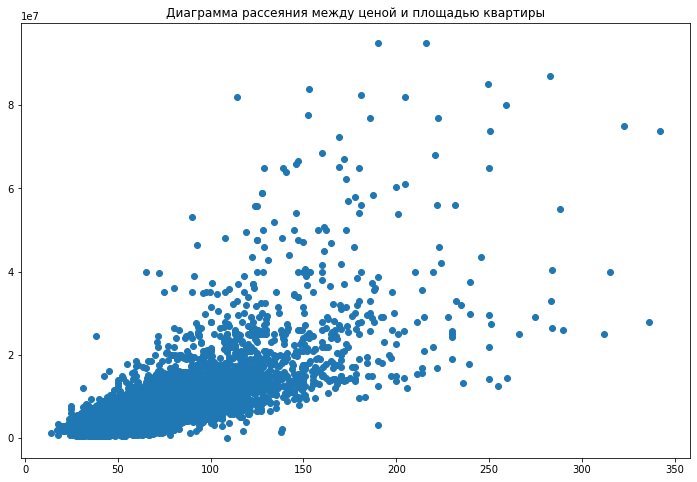

In [13]:
# Строим диаграмму рассеяния между ценой и площадью квартиры
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Диаграмма рассеяния между ценой и площадью квартиры',fontsize=12)
ax.scatter(x=df_good['total_area'], y=df_good['last_price'])

print('Коэффициент корреляции: {:.2f}'.format(df_good['last_price'].corr(df_good['total_area'])))

#### Вывод
С ростом общей площади квартиры увеличивается ее цена, однако присутствуют выбросы. Важную роль играет расположение квартиры. (Маленькая однокомнатная квартира в центре большого города будет стоить дороже большей квартиры в области)

Коэффициент корреляции: 0.96


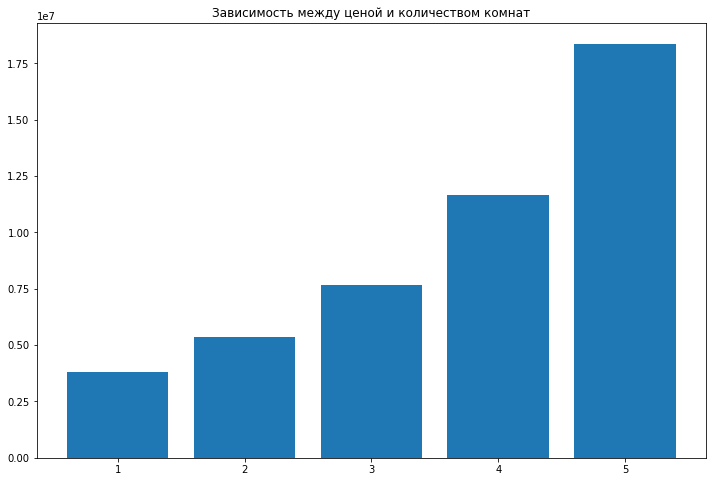

In [14]:
# Посчитаем среднюю стоимость квартиры с каждым количеством комнат
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Зависимость между ценой и количеством комнат',fontsize=12)
ax.bar(x=sorted(df_good['rooms'].unique()), height=df_good.groupby('rooms')['last_price'].mean())
print('Коэффициент корреляции: {:.2f}'.format((np.corrcoef(x=df_good['rooms'].unique(), y=df_good.groupby('rooms')['last_price'].mean()))[0,1]))

#### Вывод
Средняя стоимость квартиры увеличивается с увеличением количества комнат. Коэффициент корреляции: 0.96

<BarContainer object of 3 artists>

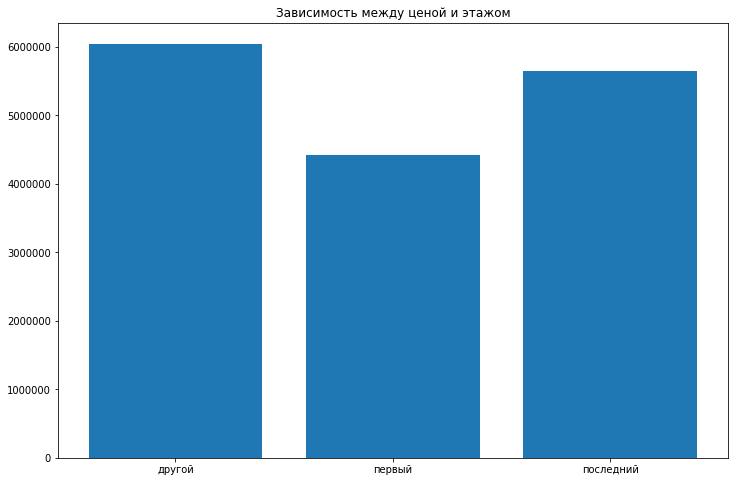

In [15]:
# Посчитаем среднюю стоимость квартиры на каждой из категорий этажей
#print(df_good.groupby('floor_cat')['last_price'].mean())
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Зависимость между ценой и этажом',fontsize=12)
ax.bar(x=sorted(df_good['floor_cat'].unique()), height=df_good.groupby('floor_cat')['last_price'].mean())

#### Вывод
Самые дешевые квартиры на первом этаже. Самые дорогие - не на первом и не на последнем.

Коэффициент корреляции: -0.23


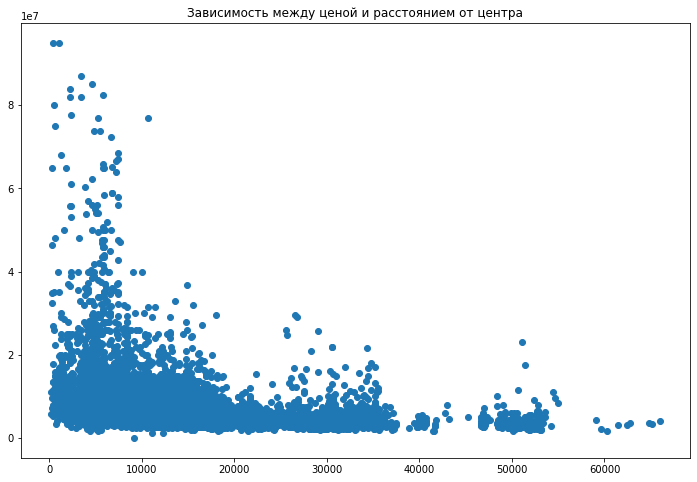

In [16]:
# Строим диаграмму рассеяния между ценой и расстоянием от центра квартиры
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Зависимость между ценой и расстоянием от центра',fontsize=12)
ax.scatter(x=df_good['cityCenters_nearest'], y=df_good['last_price'])
print('Коэффициент корреляции: {:.2f}'.format(df_good['cityCenters_nearest'].corr(df_good['total_area'])))

#### Вывод
Корреляция между стоимостью квартиры и расстоянием от центра города прослеживается (чем ближе к центру, тем дороже), но не сильная (Коэффициент корреляции = -0.23).

<BarContainer object of 6 artists>

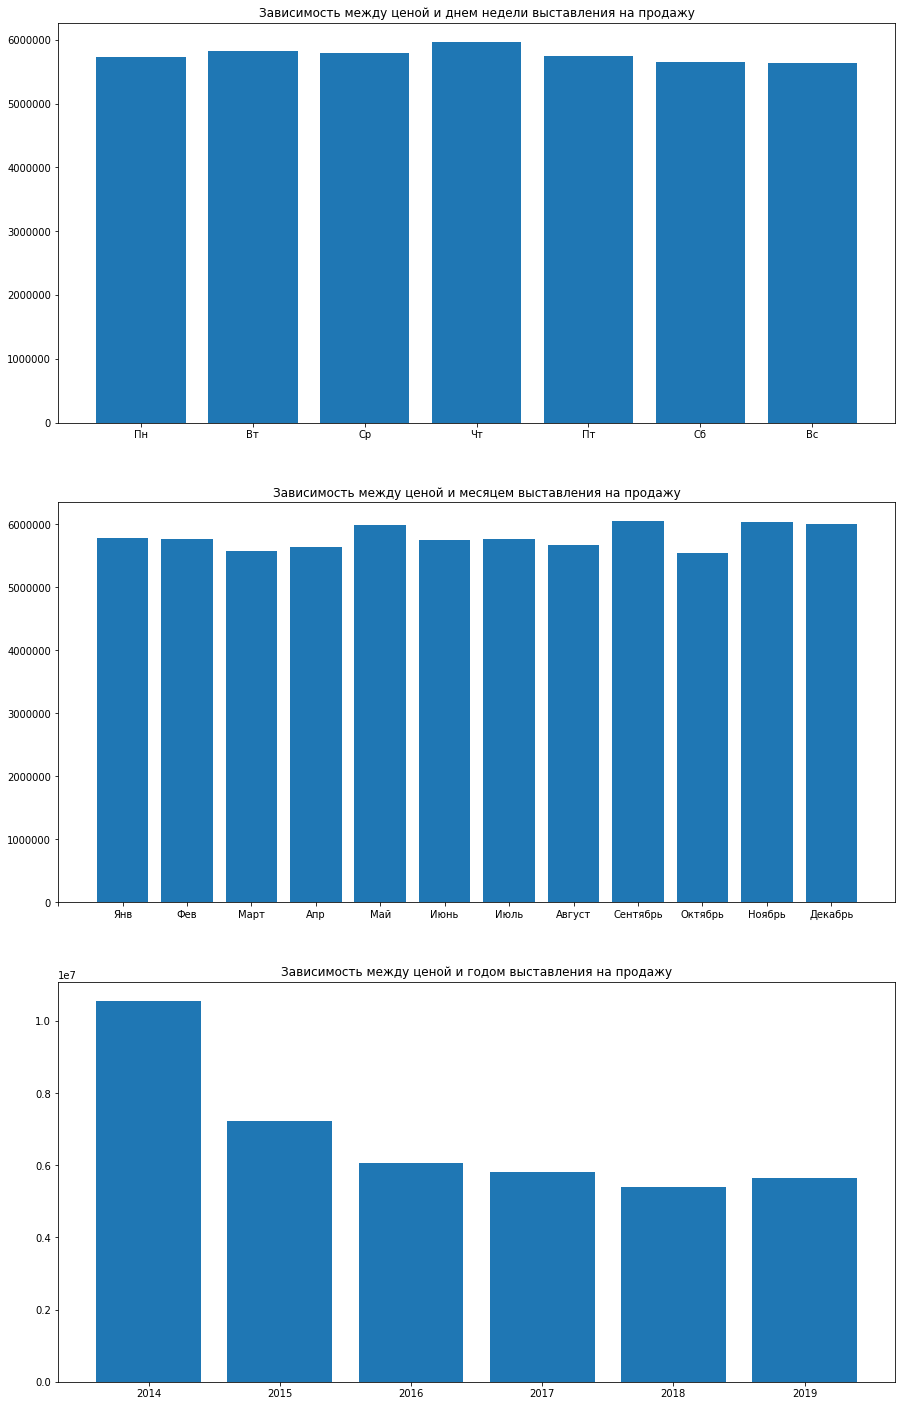

In [17]:
# Построим зависимости стоимости квартиры от дня недели, месяца и года выставления на продажу
fig, ax = plt.subplots(3,1,figsize=(15, 25))
ax[0].set_title('Зависимость между ценой и днем недели выставления на продажу',fontsize=12)
ax[0].bar(x=sorted(df_good['day_of_week'].unique()), height=df_good.groupby('day_of_week')['last_price'].mean())
days = ['Пн','Вт','Ср','Чт','Пт','Сб','Вс']
y_pos = np.arange(len(days))
ax[0].set_xticklabels(days)
ax[0].set_xticks(y_pos)


ax[1].set_title('Зависимость между ценой и месяцем выставления на продажу',fontsize=12)
ax[1].bar(x=sorted(df_good['month'].unique()), height=df_good.groupby('month')['last_price'].mean())
months = ['','Янв','Фев','Март','Апр','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']
y_pos2 = np.arange(len(months))
ax[1].set_xticklabels(months)
ax[1].set_xticks(y_pos2)


ax[2].set_title('Зависимость между ценой и годом выставления на продажу',fontsize=12)
ax[2].bar(x=sorted(df_good['year'].unique()), height=df_good.groupby('year')['last_price'].mean())






#### Вывод
Средняя стоимость квартиры не зависит от дня и месяца даты размещения, однако по годам можно проследить изменение цен на квартиры. В 2014 году цены в среднем были выше, в 2015 году цена упала, а с 2016 года более или менее зафиксировалась.


<a id='part4.5'></a>
### 4.5 Стоимость квадратного метра в разных городах.

In [18]:
# Убираем пропуски в названиях и приводим названия к одному виду
df_good = df_good[df_good['locality_name'].notnull()]
# Функция для переименования населенных пунктов
def new_locality_name(row):
    locality_name = row['locality_name'] 
    
    for i in range(len(locality_name.split())): # Делим строку на слова
        answ=''
        if locality_name.split()[i].istitle(): # Если слово начинается с заглавной буквы, формируем название города
            name = locality_name.split()[i:]
            if len(name)==2:                   # Если название города состоит из 2 слов 
                name = name[0] + ' ' + name[1]
            if len(name)==3:                   # Если название города состоит из 3 слов
                name = name[0] + ' ' + name[1] + ' ' + name[2]
            return answ.join(name)
        
df_good['new_locality_name'] = df_good.apply(new_locality_name, axis=1)
df_good['locality_name'] = df_good['new_locality_name']

print('Самый дорогой метр: {}, {:.0f} рублей'.format(df_good.groupby('locality_name')['meter_price'].mean()
                                                            .sort_values(ascending=False).index[0],
                                                     df_good.groupby('locality_name')['meter_price'].mean()
                                                            .sort_values(ascending=False)[0]))
print('Самый дешевый метр: {}, {:.0f} рублей'.format(df_good.groupby('locality_name')['meter_price'].mean()
                                                            .sort_values(ascending=True).index[0],
                                                     df_good.groupby('locality_name')['meter_price'].mean()
                                                            .sort_values(ascending=True)[0]))


# Определим 10 городов с наибольшим кол-вом объявлений
biggest10_list = df_good.groupby('locality_name')['meter_price'].count().sort_values(ascending=False).index[0:10]
print('Средняя стоимость квадратного метра в топ-10 городов с наибольшим числом объявлений')
# Считает среднюю стоимость кв метра в этих горродах
print(df_good.query('locality_name in @biggest10_list').groupby('locality_name')['meter_price']
                                                           .mean().sort_values(ascending=False))

Самый дорогой метр: Зеленогорск, 111332 рублей
Самый дешевый метр: Старополье, 11206 рублей
Средняя стоимость квадратного метра в топ-10 городов с наибольшим числом объявлений
locality_name
Санкт-Петербург    110458.819162
Пушкин             102062.415652
Кудрово             94052.585954
Парголово           89743.290223
Мурино              85131.226689
Шушары              77659.421862
Колпино             74583.051418
Всеволожск          68827.209415
Гатчина             67955.616392
Выборг              57123.503229
Name: meter_price, dtype: float64


#### Вывод
Самая высокая стоимость квадратного метра в Зеленогорске (111332).

Самая низкая стоимость квадратного метра в Старополье (11206).

<a id='part4.6'></a>
### Определение квартир, находящихся в центре Санкт-Петербурга

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Цена, руб')

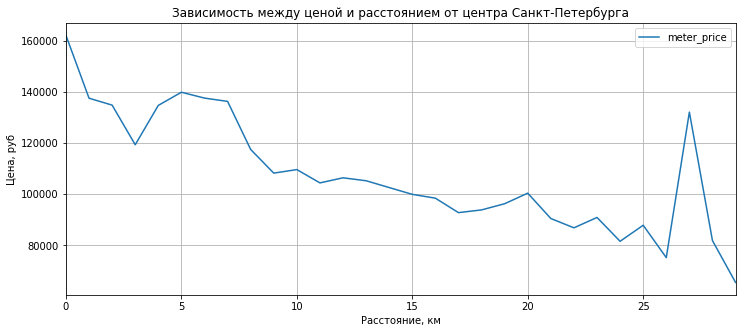

In [19]:
# Выведем в отдельную таблицу данные по СПБ
df_good_spb = df_good.query('locality_name == "Санкт-Петербург"')
# В столбце расстояний до центра обработка пропусков не производилась, обнаружился 21 пропуск. Удалим.
df_good_spb.dropna(subset=['cityCenters_nearest'], inplace=True)
# Переводим расстояние до центра в целые километры
df_good_spb['distance_center_km'] = (df_good_spb['cityCenters_nearest'] / 1000).astype('int')

# Строим график зависимости средней цены квадратного метра от удаленности от центра СПБ
#fig, ax = plt.subplots(figsize=(12, 5))
#ax.set_title('Зависимость между ценой и расстоянием от центра Санкт-Петербурга',fontsize=12)
#ax[0].plot(x=sorted(df_good['day_of_week'].unique()), y=df_good.groupby('day_of_week')['last_price'].mean())

(df_good_spb
            .pivot_table(index='distance_center_km', values='meter_price')
            .plot(grid=True, figsize=(12, 5)))
plt.title('Зависимость между ценой и расстоянием от центра Санкт-Петербурга',fontsize=12)
plt.xlabel('Расстояние, км')
plt.ylabel('Цена, руб')

#### Вывод
Самая высокая цена на расстоянии 0 км от центра, далее до 3 км цена падает, а затем снова делает скачок наверх.

Центральной зоной будем считать расстояние до 3 км от центра.

<a id='part4.7'></a>
### 4.7 Сравнение квартир в центре Санкт-Петербурга со всеми квартирами Санкт-Петербурга

Средняя площадь по всему городу: 60.6
Средняя площадь в центре: 60.6


Text(3.5, 125, 'Средняя высота потолков \n3.1')

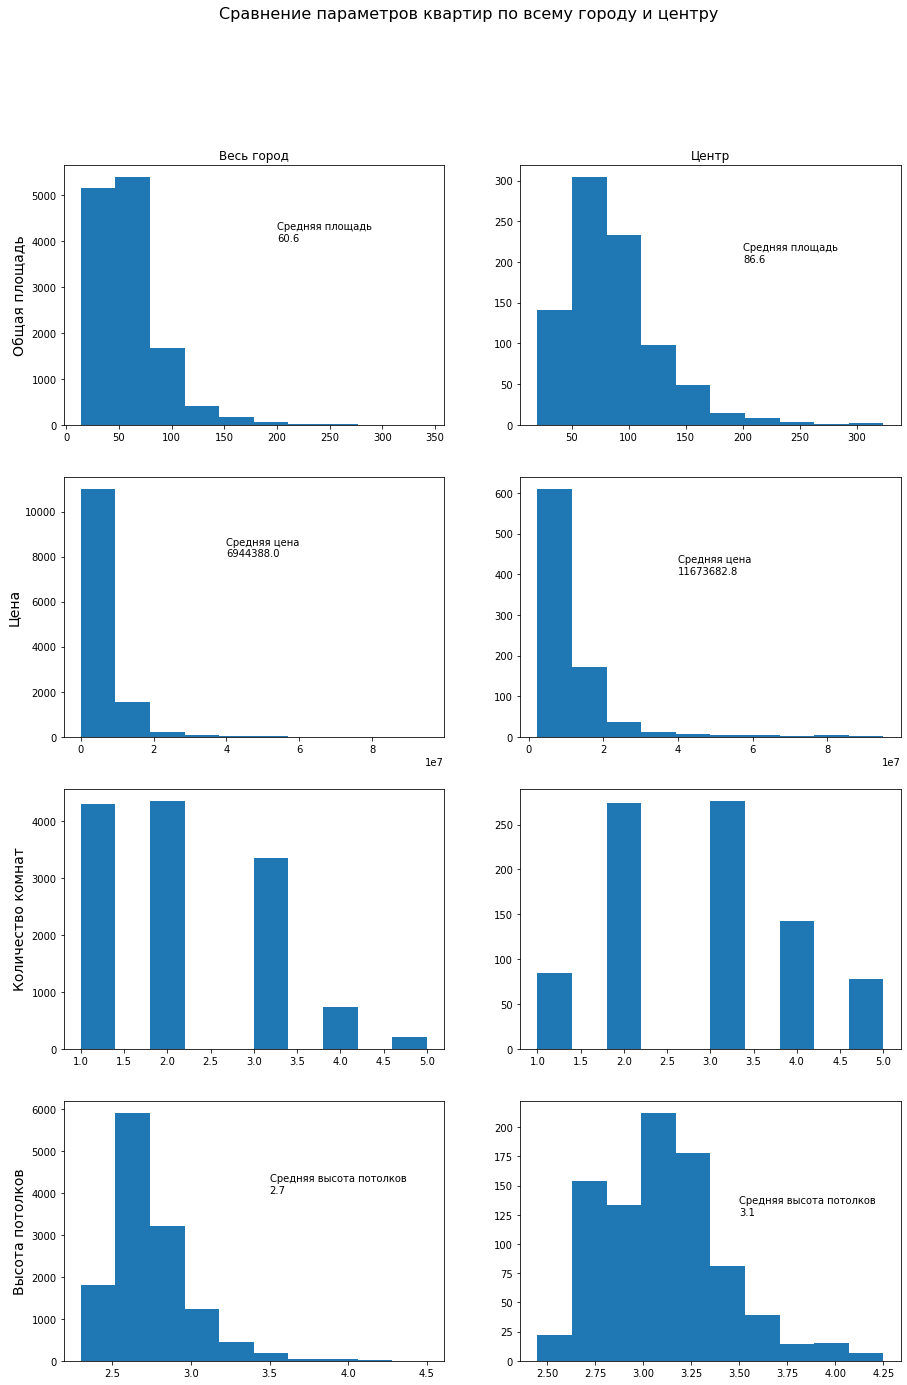

In [20]:
# Выделим объявления в центре СПБ
df_good_spb_center = df_good_spb.query('distance_center_km <= 3')

fig, axs = plt.subplots(4, 2, figsize=(15, 22))

print('Средняя площадь по всему городу: {:.1f}'.format(df_good_spb['total_area'].mean()))
print('Средняя площадь в центре: {:.1f}'.format(df_good_spb['total_area'].mean()))

# Рисуем графики
axs[0,0].hist(df_good_spb['total_area'])
axs[0,1].hist(df_good_spb_center['total_area'])
axs[1,0].hist(df_good_spb['last_price'])
axs[1,1].hist(df_good_spb_center['last_price'])
axs[2,0].hist(df_good_spb['rooms'])
axs[2,1].hist(df_good_spb_center['rooms'])
axs[3,0].hist(df_good_spb['ceiling_height'])
axs[3,1].hist(df_good_spb_center['ceiling_height'])

# Подписи
axs[0,0].title.set_text('Весь город')
axs[0,1].title.set_text('Центр')
plt.suptitle("Сравнение параметров квартир по всему городу и центру", fontsize=16)
axs[0,0].set_ylabel('Общая площадь', fontsize=14)
axs[1,0].set_ylabel('Цена',fontsize=14)
axs[2,0].set_ylabel('Количество комнат',fontsize=14)
axs[3,0].set_ylabel('Высота потолков',fontsize=14)

axs[0,0].text(200, 4000, 'Средняя площадь \n{:.1f}'.format(df_good_spb['total_area'].mean()))
axs[0,1].text(200, 200, 'Средняя площадь \n{:.1f}'.format(df_good_spb_center['total_area'].mean()))
axs[1,0].text(40000000, 8000, 'Средняя цена \n{:.1f}'.format(df_good_spb['last_price'].mean()))
axs[1,1].text(40000000, 400, 'Средняя цена \n{:.1f}'.format(df_good_spb_center['last_price'].mean()))
axs[3,0].text(3.5, 4000, 'Средняя высота потолков \n{:.1f}'.format(df_good_spb['ceiling_height'].mean()))
axs[3,1].text(3.5, 125, 'Средняя высота потолков \n{:.1f}'.format(df_good_spb_center['ceiling_height'].mean()))

#### Вывод

В центре Санкт-Петербурга (круг радиусом 3 км) квартиры в среднем больше, дороже, выше и имеют большее количество комнат.

Text(2017, 15000000, 'r = -0.09')

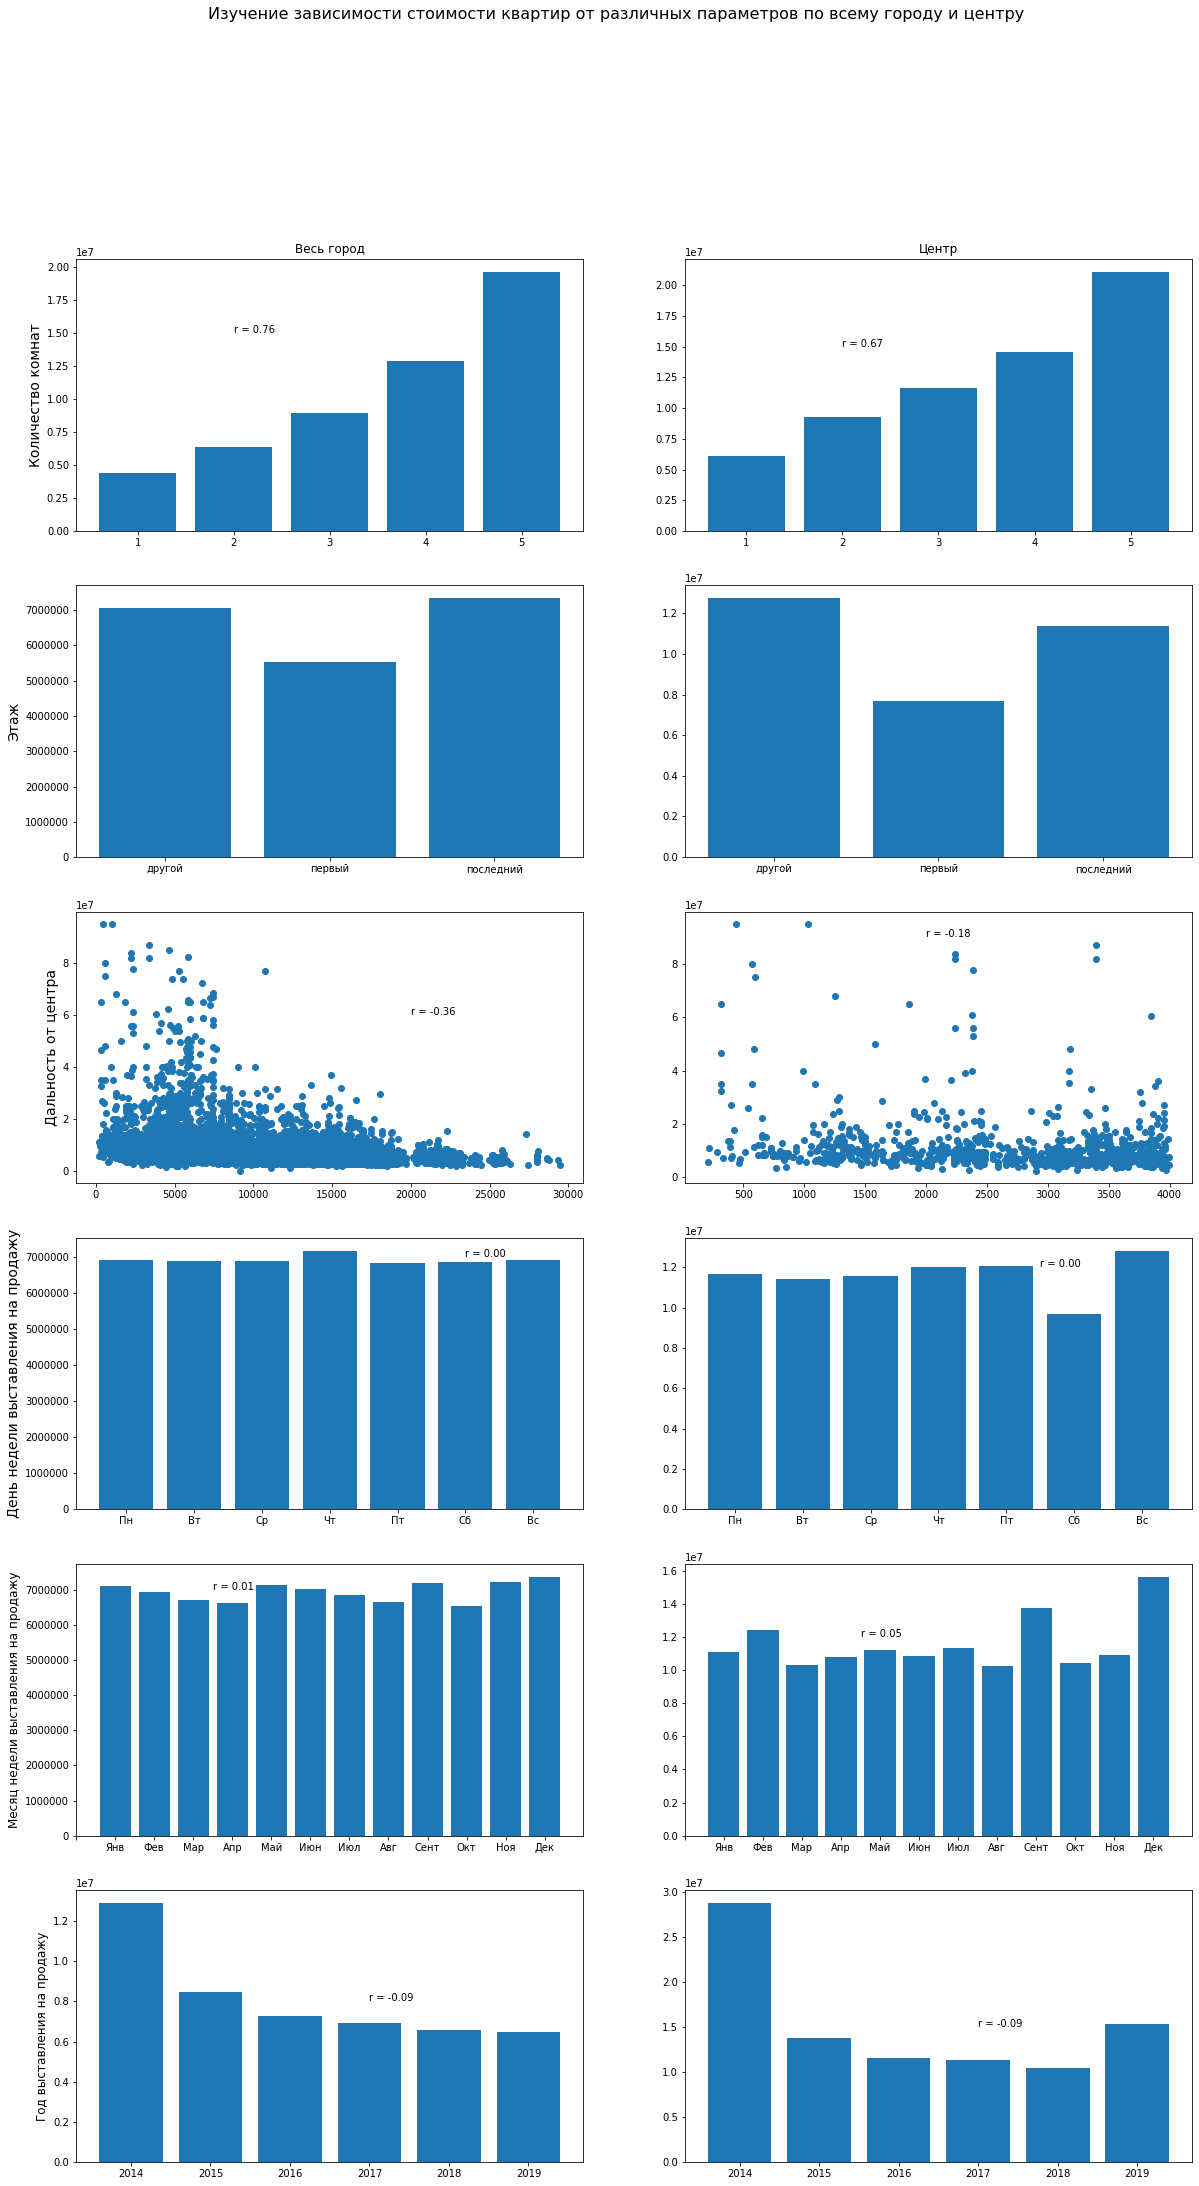

In [21]:
fig, ax = plt.subplots(6,2,figsize=(20, 35))
# Строим зависимость между количеством комнат и ценой
ax[0,0].bar(x=sorted(df_good_spb['rooms'].unique()), height=df_good_spb.groupby('rooms')['last_price'].mean())
ax[0,1].bar(x=sorted(df_good_spb_center['rooms'].unique()), height=df_good_spb_center.groupby('rooms')['last_price'].mean())
# Строим зависимость между этажом и ценой
ax[1,0].bar(x=sorted(df_good_spb['floor_cat'].unique()), height=df_good_spb.groupby('floor_cat')['last_price'].mean())
ax[1,1].bar(x=sorted(df_good_spb_center['floor_cat'].unique()), height=df_good_spb_center.groupby('floor_cat')['last_price'].mean())
# Строим зависимость между расстоянием от центра и ценой
ax[2,0].scatter(x=df_good_spb['cityCenters_nearest'], y=df_good_spb['last_price'])
ax[2,1].scatter(x=df_good_spb_center['cityCenters_nearest'], y=df_good_spb_center['last_price'])
# Строим зависимость между датой выставления на продажу(день недели) и ценой
ax[3,0].bar(x=sorted(df_good_spb['day_of_week'].unique()), height=df_good_spb.groupby('day_of_week')['last_price'].mean())
ax[3,1].bar(x=sorted(df_good_spb_center['day_of_week'].unique()), height=df_good_spb_center.groupby('day_of_week')['last_price'].mean())
days = ['Пн','Вт','Ср','Чт','Пт','Сб','Вс']
y_pos = np.arange(len(days))
ax[3,0].set_xticklabels(days)
ax[3,0].set_xticks(y_pos)
ax[3,1].set_xticklabels(days)
ax[3,1].set_xticks(y_pos)
# Строим зависимость между датой выставления на продажу(месяц) и ценой
ax[4,0].bar(x=sorted(df_good_spb['month'].unique()), height=df_good_spb.groupby('month')['last_price'].mean())
ax[4,1].bar(x=sorted(df_good_spb_center['month'].unique()), height=df_good_spb_center.groupby('month')['last_price'].mean())
months = ['','Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сент','Окт','Ноя','Дек']
y_pos2 = np.arange(len(months))
ax[4,0].set_xticklabels(months)
ax[4,0].set_xticks(y_pos2)
ax[4,1].set_xticklabels(months)
ax[4,1].set_xticks(y_pos2)
# Строим зависимость между датой выставления на продажу(год) и ценой
ax[5,0].bar(x=sorted(df_good_spb['year'].unique()), height=df_good_spb.groupby('year')['last_price'].mean())
ax[5,1].bar(x=sorted(df_good_spb_center['year'].unique()), height=df_good_spb_center.groupby('year')['last_price'].mean())

#ax[6,0].scatter(x=df_good_spb['rooms'], y=df_good_spb['last_price'])
#ax[6,1].scatter(x=df_good_spb_center['rooms'], y=df_good_spb_center['last_price'])

# Подписи
plt.suptitle("Изучение зависимости стоимости квартир от различных параметров по всему городу и центру", fontsize=16)

ax[0,0].title.set_text('Весь город')
ax[0,1].title.set_text('Центр')

ax[0,0].set_ylabel('Количество комнат', fontsize=14)
ax[1,0].set_ylabel('Этаж',fontsize=14)
ax[2,0].set_ylabel('Дальность от центра',fontsize=14)
ax[3,0].set_ylabel('День недели выставления на продажу',fontsize=14)
ax[4,0].set_ylabel('Месяц недели выставления на продажу',fontsize=12)
ax[5,0].set_ylabel('Год выставления на продажу',fontsize=12)

ax[0,0].text(2, 15000000, 'r = {:.2f}'.format(df_good_spb['last_price'].corr(df_good_spb['total_area'])))
ax[0,1].text(2, 15000000, 'r = {:.2f}'.format(df_good_spb_center['last_price'].corr(df_good_spb_center['total_area'])))
ax[2,0].text(20000, 60000000, 'r = {:.2f}'.format(df_good_spb['last_price'].corr(df_good_spb['cityCenters_nearest'])))
ax[2,1].text(2000, 90000000, 'r = {:.2f}'.format(df_good_spb_center['last_price'].corr(df_good_spb_center['cityCenters_nearest'])))
ax[3,0].text(5, 7000000, 'r = {:.2f}'.format(df_good_spb['last_price'].corr(df_good_spb['day_of_week'])))
ax[3,1].text(4.5, 12000000, 'r = {:.2f}'.format(df_good_spb_center['last_price'].corr(df_good_spb_center['day_of_week'])))
ax[4,0].text(3.5, 7000000, 'r = {:.2f}'.format(df_good_spb['last_price'].corr(df_good_spb['month'])))
ax[4,1].text(4.5, 12000000, 'r = {:.2f}'.format(df_good_spb_center['last_price'].corr(df_good_spb_center['month'])))
ax[5,0].text(2017, 8000000, 'r = {:.2f}'.format(df_good_spb['last_price'].corr(df_good_spb['year'])))
ax[5,1].text(2017, 15000000, 'r = {:.2f}'.format(df_good_spb_center['last_price'].corr(df_good_spb_center['year'])))

#### Вывод

Зависимость стоимости квартир от изученных параметров(количество комнат, этаж, расстояние от центра, дата размещения обхявления) в центре Санкт-Петербурга немного отличается от такой же зависимости для всего города.

Зависимость от количества комнат практически не отличается. (R в центре меньше на 0.09)

В центре Санкт-Петербурга квартиры на последнем этаже дороже квартир на всех этажах, кроме первого. Если рассматривать весь город, то наоборот.

В центре Санкт-Петербурга стоимость квартир коррелирует с расстоянием от центра в два раза хуже. В итоге по всему городу принцип "чем ближе к центру, тем дороже" более или менее соблюдается (r = -0.36), а в центре практически нет (высокий коэффициент корреляции обусловлен большим отношение количества выбросов ко всему срезу данных)

Стоимость квартиры от дня и месяца размещения объявления не зависит, однако наблюдается странный выброс в Санкт-Петербурге в субботу, а также выбросы в Санкт-Петербурге в сентябре и декабре.

Начиная с 2014 года стоимость квартир по всему Санкт-Петербургу начала уменьшаться, но в 2019 году в центре цена начала расти.



<a id='part5'></a>
## Общий вывод

В процессе исследования данных Яндекс.Недвижимости были предобработаны данные (удалены пропуски и дубликаты)

Добавлены данные дополнительные данные в таблицу.

Удалены редкие и выбивающиеся значения.

Изучены факторы, влияющие на стоимость квартиры по всем данным.

Выделены города с наибольшим количеством объявлений, а также с самой высокой и самой низкой стоимостью квадратного метра жилья.

Изучены факторы, влияющие на стоимость квартиры в Санкт-Петербурге, отдельно изучена центральная область Санкт-Петербурга (радиус 3км).